# Frequency domain error index

This notebook will explore the Frequency Domain Error (FDE) index (found [here][WILEY] and [here][RESEARCHGATE]), a way of computing the difference between a computed and a measured signal in the frequency domain instead of the time domain.

[WILEY]: http://onlinelibrary.wiley.com/doi/10.1002/eqe.951/abstract

[RESEARCHGATE]: https://www.researchgate.net/publication/244968640_FDE_index_for_goodness-of-fit_between_measured_and_calculated_response_signals

This index is computed using the following formula:

$$FDE\ index = \frac {\sum_{i=0}^{n}{FFT(measured-computed)}} {\sum_{i=0}^{n} \left({FFT(computed)+FFT(measured)}\right)}$$

where $n$ is the last Fourier component of the signal. It has the interesting property that its values are bound between **zero** and **one**, meaning the former a perfect match between the two signals and the latter a complete opposition between them.

## Computational lab setup

In [1]:
%matplotlib inline

import sys

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl

from numpy.fft import rfft, rfftfreq
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

print(sys.version)
for module in (np, sp, pd, mpl):
    print('{:.<15}{}'.format(module.__name__, module.__version__))

3.5.2 |Anaconda 4.3.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
numpy..........1.11.3
scipy..........0.18.1
pandas.........0.19.2
matplotlib.....2.0.0


Helper functions:

In [2]:
def rms(a, axis=None, dtype=None, out=None, keepdims=np._NoValue):
    """Compute the root mean square along the specified axis."""
    return np.sqrt(np.mean(np.square(a), axis=axis, dtype=dtype, out=out, keepdims=keepdims))

The function to compute the FDE index according to the formula above is the following:

In [3]:
def FDEindex(computed, measured, nfft=None, axis=-1, nsum=None):
    """Compute the Frequency Domain Error (FDE) index between computed and measured signals.
    
    Parameters
    ----------
    computed : array_like
        Computed signal.
    measured : array_like
        Measured signal.
    nfft : int, optional
        Number of points along transformation axis in the input to use by rfft.
        If `nfft` is smaller than the length of the input, the input is cropped.
        If it is larger, the input is padded with zeros.
        If `nfft` is not given, the length of the input along the axis specified by `axis` is used.
    axis : int, optional
        Axis over which to compute the FDEindex. If not given, the last axis is used.
    nsum : int, optional
        Number of points along transformation axis in the input to use by sum.
        If `nsum` is not given, the length of the input along the axis specified by `axis` is used.
    
    Returns
    -------
    out : ndarray
        An array with the same shape as computed and measured, with the specified axis removed.
        If computed and measured are 0-d arrays, a scalar is returned.
    
    Raises
    ------
    ValueError
        If computed and measured parameters have different shapes or if axis is None.
    
    See also
    --------
    numpy.fft.rfft : For the definition of the rfft function.
    numpy.sum : For the definition of the sum function.

    Notes
    -----
    This function is implemented using rfft and sum.
    The parameter nfft is used by rfft while nsum is used by sum.
    
    Examples
    --------
    >>> FDEindex([0,1,2,1,0,-1,-2,-1], [0,1,2,1,0,-1,-2,-1]) # perfect match
    0.0
    >>> FDEindex([0,1,2,1,0,-1,-2,-1], [-1,0,1,2,1,0,-1,-2]) # time delay
    0.461939766256
    >>> FDEindex([0,1,2,1,0,-1,-2,-1], [0,-1,-2,-1,0,1,2,1]) # opposite phase
    1.0
    
    Reference
    ---------
    Jeff J. Dragovich and Andres Lepage
        FDE index for goodness-of-fit between measured and calculated response signal (SHORT COMMUNICATION)
        EARTHQUAKE ENGINEERING AND STRUCTURAL DYNAMICS, 2009; 38:1751–1758
        http://onlinelibrary.wiley.com/doi/10.1002/eqe.951/abstract
        https://www.researchgate.net/publication/244968640_FDE_index_for_goodness-of-fit_between_measured_and_calculated_response_signals
    """
    computed = np.asarray(computed)
    measured = np.asarray(measured)
    if computed.shape != measured.shape:
        raise ValueError('computed and measured parameters have different shapes!')
    elif axis is None:
        raise ValueError('axis can not be None!')
    COMPUTED = rfft(computed, n=nfft, axis=axis)
    MEASURED = rfft(measured, n=nfft, axis=axis)
    nfft = COMPUTED.shape[axis]
    if nsum is None or nsum > nfft:
        nsum = nfft
    num = np.sum(np.absolute(MEASURED[:nfft]-COMPUTED[:nfft]), axis=axis)
    den = np.sum(np.absolute(COMPUTED[:nfft])+np.absolute(MEASURED[:nfft]), axis=axis)
    return num/den

Let us test the significance of this index in some simple but illustrative cases. First, consider two equal harmonic waves:

FDE index=0.00, RMS error=0.00


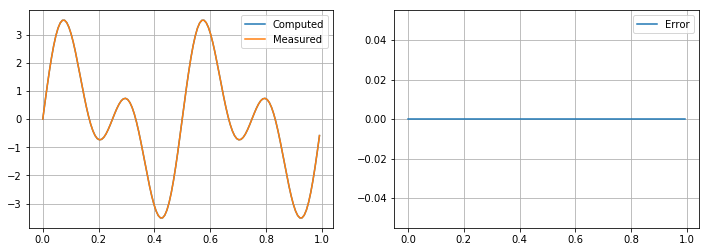

In [4]:
Ns = 128
tt = np.arange(Ns)/Ns
Ac = 2.
fc = 2.
sc = Ac*(np.sin(2.*np.pi*fc*tt)+np.sin(2.*2.*np.pi*fc*tt))
sm = sc
se = sm-sc
FDE = FDEindex(sc, sm)
RMS = rms(se)
print('FDE index={:.2f}, RMS error={:.2f}'.format(FDE, RMS))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(tt, sc, label='Computed')
ax[0].plot(tt, sm, label='Measured')
ax[0].legend()
ax[0].grid(b=True)
ax[1].plot(tt, se, label='Error')
ax[1].legend()
ax[1].grid(b=True)

Naturally, the FDE index yields 0. Next, we will use the same harmonic waves but we will delay the measured by one sample:

FDE index=0.07, RMS error=0.31


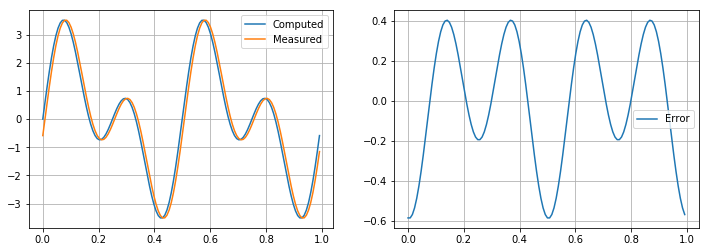

In [5]:
sm1 = np.roll(sc, 1)
se1 = sm1-sc
FDE1 = FDEindex(sc, sm1)
RMS1 = rms(se1)
print('FDE index={:.2f}, RMS error={:.2f}'.format(FDE1, RMS1))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(tt, sc, label='Computed')
ax[0].plot(tt, sm1, label='Measured')
ax[0].legend()
ax[0].grid(b=True)
ax[1].plot(tt, se1, label='Error')
ax[1].legend()
ax[1].grid(b=True)

Of course, if the measured signal is equal to the computed signal multiplied by -1 than the FDE index will render 1:

FDE index=1.00, RMS error=4.00


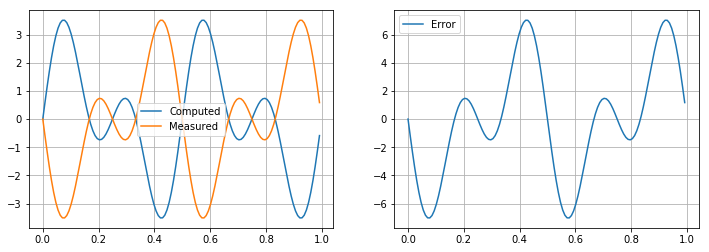

In [6]:
sm2 = -sc
se2 = sm2-sc
FDE2 = FDEindex(sc, sm2)
RMS2 = rms(se2)
print('FDE index={:.2f}, RMS error={:.2f}'.format(FDE2, RMS2))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(tt, sc, label='Computed')
ax[0].plot(tt, sm2, label='Measured')
ax[0].legend()
ax[0].grid(b=True)
ax[1].plot(tt, se2, label='Error')
ax[1].legend()
ax[1].grid(b=True)

And what about additive uniform white noise?

FDE index=0.27, RMS error=0.30


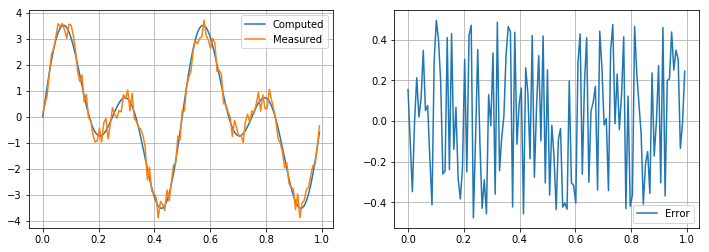

In [7]:
sm3 = sm+(np.random.random(Ns)-0.5)
se3 = sm3-sc
FDE3 = FDEindex(sc, sm3)
RMS3 = rms(se3)
print('FDE index={:.2f}, RMS error={:.2f}'.format(FDE3, RMS3))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(tt, sc, label='Computed')
ax[0].plot(tt, sm3, label='Measured')
ax[0].legend()
ax[0].grid(b=True)
ax[1].plot(tt, se3, label='Error')
ax[1].legend()
ax[1].grid(b=True)

So we see that the FDE index is indeed a good indicator for the error between the computed and measured signals, with more significance than the RMS since it is bound between zero and one.

In [8]:
data = np.array(((FDE, RMS), (FDE1, RMS1), (FDE2, RMS2), (FDE3, RMS3)))
index = ('Equal', 'Delay 1', 'Times -1', 'Add UWN')
columns = ('FDE index', 'RMS error')
df = pd.DataFrame(data, index, columns)
print(df)

          FDE index  RMS error
Equal      0.000000   0.000000
Delay 1    0.073542   0.310032
Times -1   1.000000   4.000000
Add UWN    0.271417   0.297131


In this last case it is interesting to check what is happening in the frequency domain:

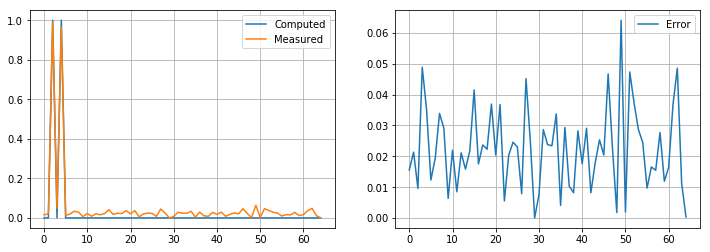

In [9]:
ff = rfftfreq(Ns, d=tt[1]-tt[0])
SCOMP = rfft(sc)/Ns
SMEAS = rfft(sm3)/Ns
SERR = SMEAS-SCOMP
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ff, np.absolute(SCOMP), label='Computed')
ax[0].plot(ff, np.absolute(SMEAS), label='Measured')
ax[0].legend()
ax[0].grid(b=True)
ax[1].plot(ff, np.absolute(SERR), label='Error')
ax[1].legend()
ax[1].grid(b=True)

Based on these examples, we will now take a completely different approach. We will define a Frequency Domain Error in spectral coordinates where, instead of summing the numerator and denominator to obtain an index, we will compute the quotient separately for each frequency bin.

This notebook was created by Paulo Xavier Candeias.